# Task 3.1

**Pre-processing and Transformation**
- *Write a Python program to pre-process and transform the dataset into a format suitable for developing machine learning models. For feature selection, you should use the filter method.*
- *Markdown Question: Explain the logic behind usage of pearson correlation coefficient for feature selection.*

## Table of Contents
- [Introduction](#Introduction)
- [Imports](#Imports)
- [Star Dataset](#Star-Dataset)
    - [Load the Star dataset](#Load-the-Star-dataset)
    - [Filling in missing values](#Filling-in-missing-values)
    - [Encoding the class labels](#Encoding-the-class-labels)
    - [Removing samples with outliers](#Removing-samples-with-outliers-star)
    - [Removing features with no variance](#Removing-features-with-no-variance-star)
    - [Feature scaling](#Feature-scaling-star)
    - [Feature selection using the filter method](#Feature-selection-using-the-filter-method-star)
- [GWP Dataset](#GWP-Dataset)
    - [Load the GWP dataset](#Load-the-GWP-dataset)
    - [Filling in missing categorical features](#Filling-in-missing-categorical-features)
    - [Encoding the categorical features](#Encoding-the-categorical-features)
    - [Filling in missing numerical features](#Filling-in-missing-numerical-features)
    - [Encoding the remaining categorical feature](#Encoding-the-remaining-categorical-feature)
    - [Removing samples with outliers](#Removing-samples-with-outliers-GWP)
    - [Removing features with no variance](#Removing-features-with-no-variance-GWP)
    - [Feature scaling](#Feature-scaling-GWP)
    - [Feature selection using the filter method](#Feature-selection-using-the-filter-method-GWP)
- [Markdown Question](#Markdown-Question)

## Introduction <a class="anchor" id="Introduction"></a>

This notebook was completed by B921400 on 08/05/2023 and is intended to fulfill and exceed the requirements of task 3.1 of the 22COC131 coursework. The first section of the notebook covers the pre-processing of the star dataset. Within this section, the dataset is loaded, missing values are filled, the class labels are encoded, outliers are removed, features with no variance are removed, the features are scaled and then selected using the filter method.

The other main section of the notebook covers this process for the GWP dataset, although this required several additional steps due to the categorical features and mixed data types present. In each section, several methods for each pre-processing step are explored and a suitable method is chosen. The notebook also contains a response to the markdown question. Several additional functions were created for use in this notebook, and these can be found in the Python files for resuability and readability purposes. The plots were created solely using Matplotlib to demonstrate the ability to use it for creating more complex plots.

## Imports <a class="anchor" id="Imports"></a>

In [3]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, MinMaxScaler, MaxAbsScaler, StandardScaler
from sklearn.feature_selection import f_classif, r_regression, SelectKBest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

# Import the functions created for reusability from the Python file
from preprocessing_utils import remove_iqr_outliers, remove_no_variance, fill_gwp_missing_dates, \
    fill_gwp_missing_quarters, fill_gwp_missing_days, handle_gwp_department, convert_date_to_cols
from plot_utils import plot_class_distribution, plot_feature_boxplot, plot_feature_scores, plot_feature_correlations

## Star Dataset <a class="anchor" id="Star-Dataset"></a>

#### Load the Star dataset <a class="anchor" id="Load-the-Star-dataset"></a>

Firstly, let's load the features, the feature names and the labels from the star dataset

In [4]:
star_file_name = 'star_assessment.csv'

# Read the features in from the dataset
star_features = np.genfromtxt(star_file_name, delimiter=',', encoding="utf-8", skip_header=True, usecols=range(0, 17))

# Read the feature names in from the dataset and remove the quotes
star_features_names = np.genfromtxt(star_file_name, delimiter=',', encoding="utf-8", usecols=range(0, 17), dtype=None, max_rows=1)
star_features_names = [name.replace('"', '') for name in star_features_names]

# Read the labels in from the dataset
star_labels = np.genfromtxt(star_file_name, delimiter=',', encoding="utf-8", skip_header=True, usecols=17, dtype=None)

Now, let's explore the dataset to see how many samples, features and classes there are

In [5]:
print(f'Number of samples: {star_features.shape[0]}')
print(f'Number of features: {star_features.shape[1]-1}')
print(f'Number of classes: {np.unique(star_labels).shape[0]}')
print(f'Class names: {np.unique(star_labels)}')

Number of samples: 100000
Number of features: 16
Number of classes: 3
Class names: ['GALAXY' 'QSO' 'STAR']


Since there are only 3 classes, the star dataset is clearly a classification task. We can also take a look at the distribution of the classes.

In [6]:
# Output the distribution of the classes
unique, counts = np.unique(star_labels, return_counts=True)
for k, v in enumerate(unique):
    print(f'{v}: {counts[k]} samples')

GALAXY: 59445 samples
QSO: 18961 samples
STAR: 21594 samples


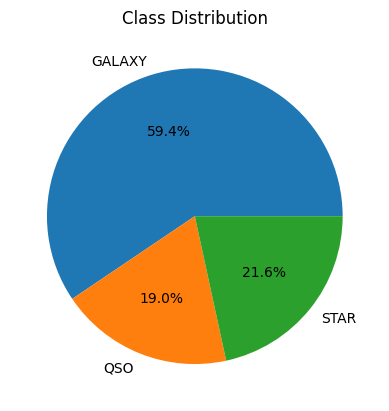

In [7]:
# Plot the distribution of the classes
plot_class_distribution(star_labels)

It is clear that galaxy is the dominant class in the dataset, with quasars and stars being represented less.

#### Filling in missing values <a class="anchor" id="Filling-in-missing-values"></a>

Let's now check if there are any missing values in the dataset

In [8]:
# Count the number of missing values in each column
missing_vals = np.sum(np.isnan(star_features), axis=0)
for k, v in enumerate(missing_vals):
    print(f'{star_features_names[k]}: {v} missing values')
print(f'Total: {sum(missing_vals)} missing values')

obj_ID: 60 missing values
alpha: 55 missing values
delta: 65 missing values
u: 70 missing values
g: 63 missing values
r: 50 missing values
i: 59 missing values
z: 61 missing values
run_ID: 59 missing values
rerun_ID: 51 missing values
cam_col: 68 missing values
field_ID: 59 missing values
spec_obj_ID: 58 missing values
redshift: 49 missing values
plate: 50 missing values
MJD: 61 missing values
fiber_ID: 62 missing values
Total: 1000 missing values


It is clear that there are many missing values in the dataset. There are a few options for dealing with these missing values:
1. Remove the samples with missing values
2. Fill the missing values with a constant
3. Fill the missing values with the mean/median of the column
4. Fill the missing values based on the values of the other features

**1. Remove the samples with missing values**

This is the simplest option, but it is not always the best as it can lead to a loss of valuable information.

In [9]:
# Remove the samples with missing values
star_features_no_missing = star_features[~np.isnan(star_features).any(axis=1)]

print(f'Total: {sum(np.sum(np.isnan(star_features_no_missing), axis=0))} missing values')

Total: 0 missing values


**2. Fill the missing values with a constant**

This is another simple option, but it can result in the model learning a bias towards the constant value.

In [10]:
simple_imputer_constant = SimpleImputer(strategy='constant', fill_value=0)
star_features_constant = simple_imputer_constant.fit_transform(star_features)

print(f'Total: {sum(np.sum(np.isnan(star_features_constant), axis=0))} missing values')

Total: 0 missing values


**3. Fill the missing values with the mean/median of the column**

This is a better option than filling with a constant, but it can still result in a bias towards the mean/median value.

In [11]:
simple_imputer_mean = SimpleImputer(strategy='mean')
star_features_mean = simple_imputer_mean.fit_transform(star_features)

print(f'Total: {sum(np.sum(np.isnan(star_features_mean), axis=0))} missing values')

Total: 0 missing values


**4. Fill the missing values based on the values of the other features**

This is the best option as it does not introduce any bias into the model. However, it is generally more computationally demanding than the other options.

In [12]:
# Use a KNN imputer to fill in the missing values
knn_imputer = KNNImputer()
star_features_imputed = knn_imputer.fit_transform(star_features)

print(f'Total: {sum(np.sum(np.isnan(star_features_imputed), axis=0))} missing values')

Total: 0 missing values


We will proceed with the KNN imputer as it is considered to be the best option for filling in the missing values.

#### Encoding the class labels <a class="anchor" id="Encoding-the-class-labels"></a>

Let's now encode the class labels so that they are represented as integers. This can be done using the LabelEncoder from scikit-learn.

In [13]:
# Encode the class labels
label_encoder = LabelEncoder()
star_labels_encoded = label_encoder.fit_transform(star_labels)

# Output the mapping between the class names and the encoded values
for k, v in enumerate(label_encoder.classes_):
    print(f'{v} : {k}')

GALAXY : 0
QSO : 1
STAR : 2


#### Removing samples with outliers <a class="anchor" id="Removing-samples-with-outliers-star"></a>

Next, let's investigate if there are any outliers in the dataset. This can be done by creating boxplots of each feature.

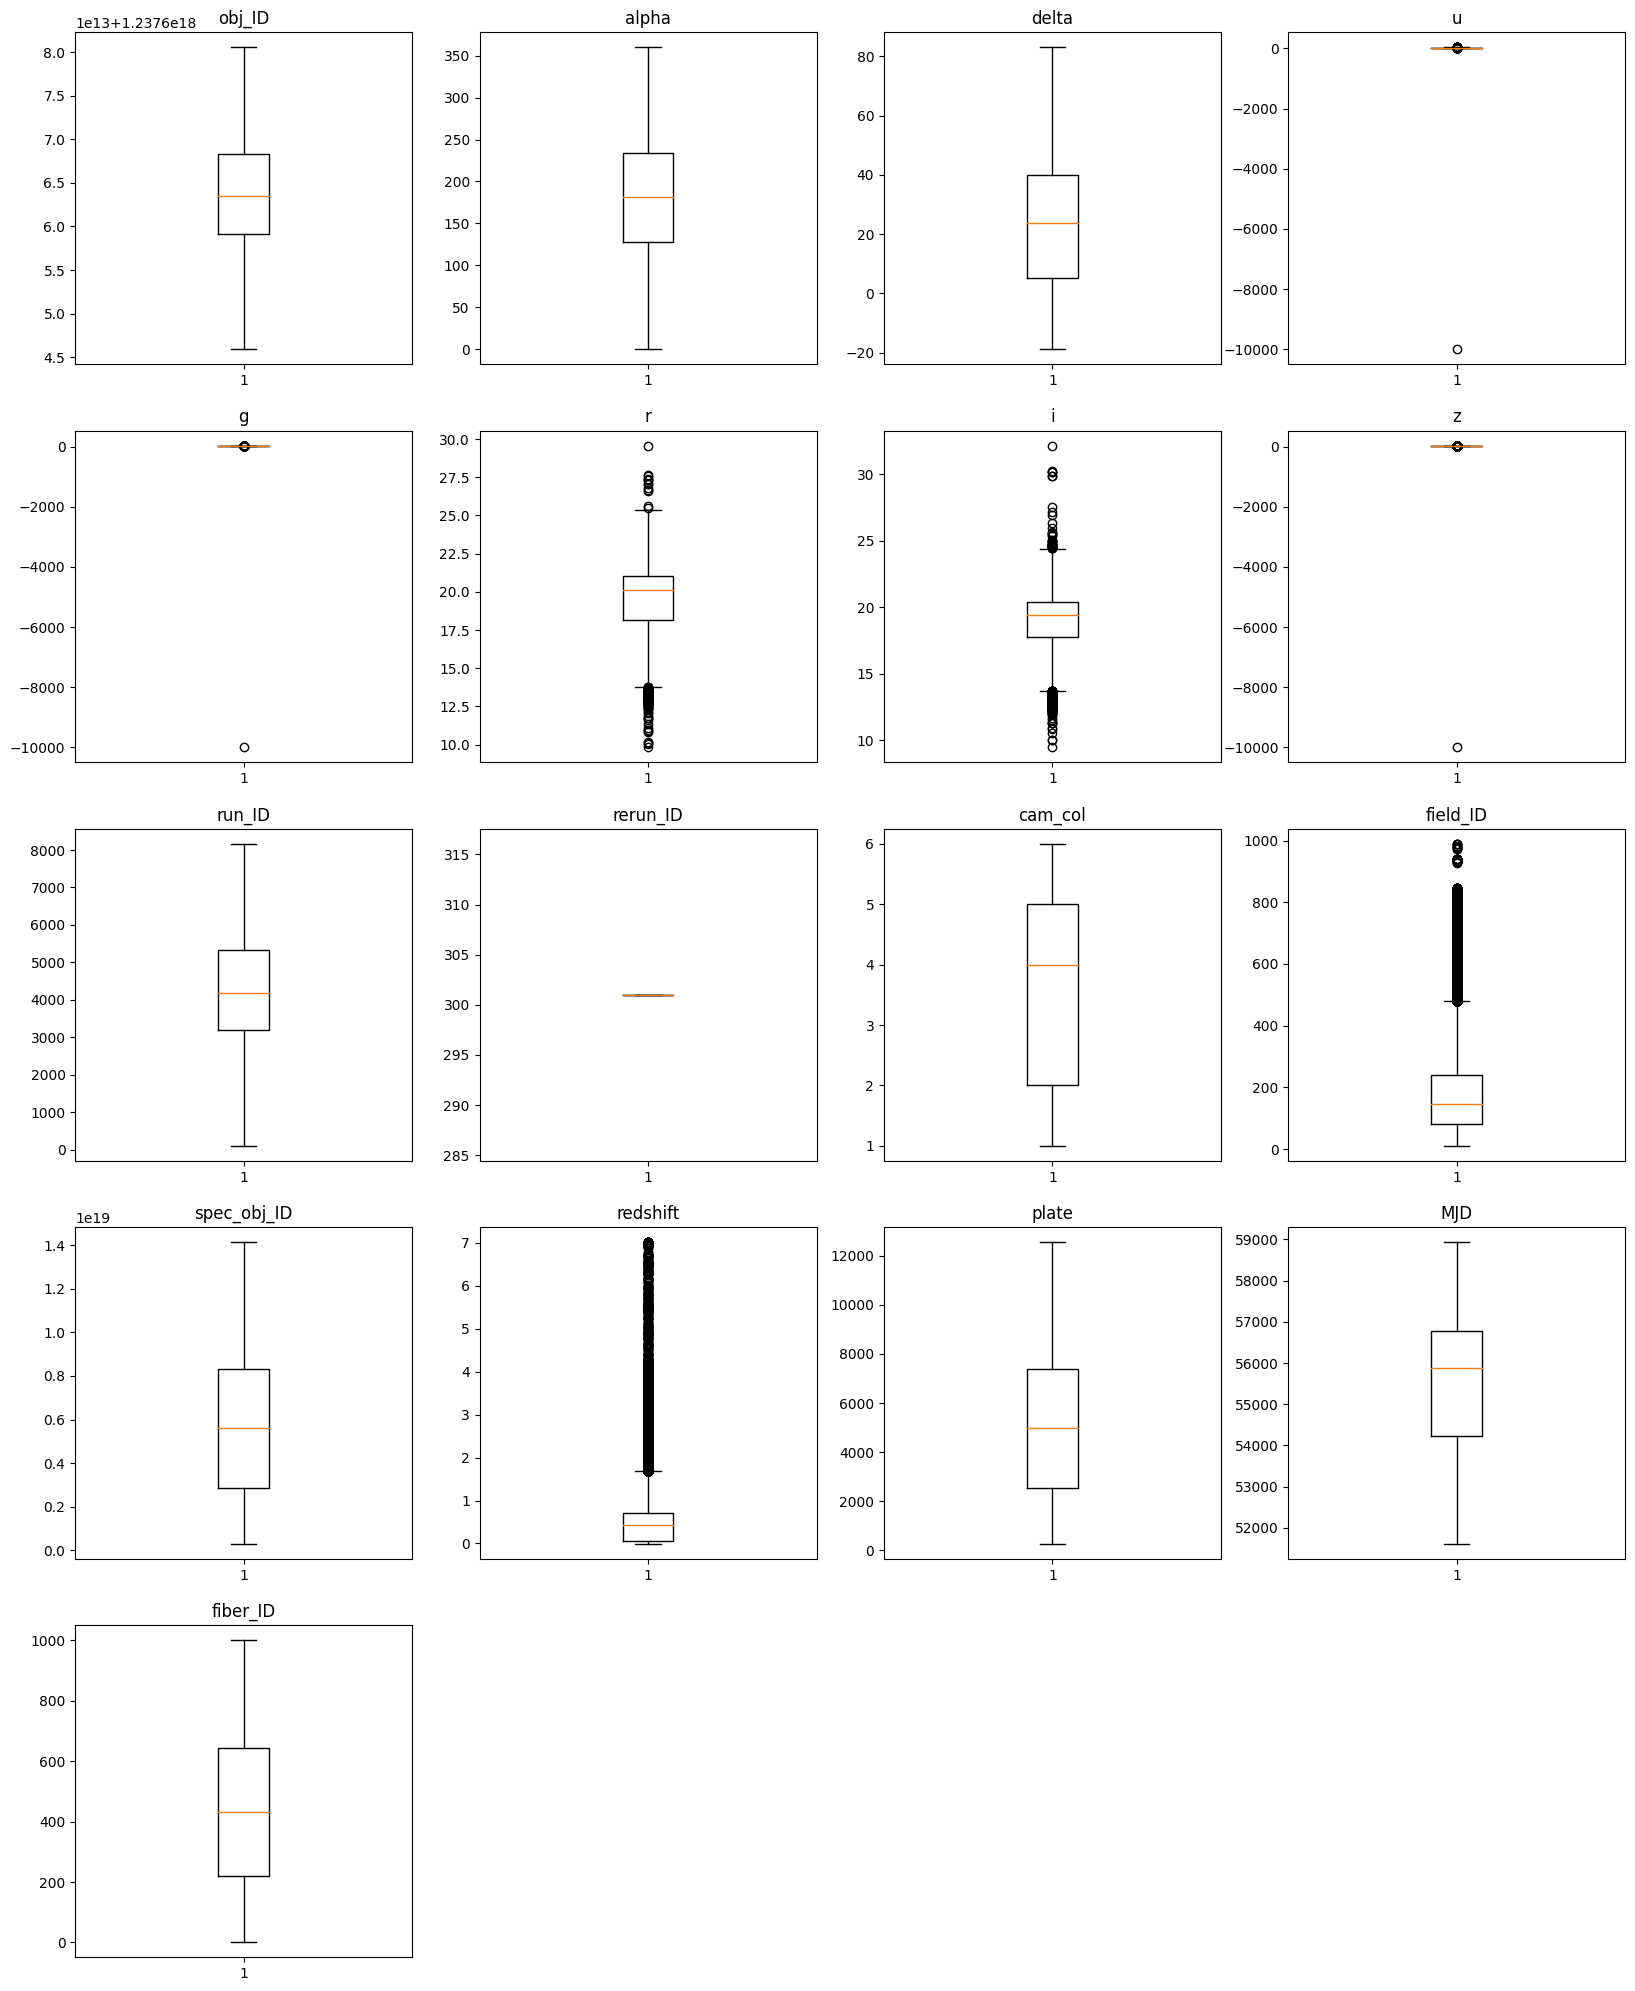

In [14]:
plot_feature_boxplot(star_features_imputed, star_features_names)

The boxplots show that there are lots of outliers present in the dataset. Curiously, the features `u`, `g`, and `z` all have a single value that lies far outside the range of the other values (as well as other outliers). This could be due to -9999 being entered where values were missing in a single sample. Other features that clearly have outliers include `r`, `i`, `field_ID` and `redshift`. The `rerun_ID` column also appears to be made up of a constant value as the boxplot is flat, which will need to be handled later. We will now investigate removing the samples that contain outliers.

Let's first remove the sample(s) that contain the extreme values of -9999 as they will negatively affect the results of the outlier detection methods.

In [15]:
# Remove the samples with extreme values of -9999
star_features_imputed = star_features_imputed[star_features_imputed[:, 0] != -9999]

There are a couple of options that will be explored for removing outliers:
1. Using Scikit-Learn's LocalOutlierFactor
2. Using Scikit-Learn's IsolationForest
3. Using the Interquartile Range (IQR) method

**1. Using Scikit-Learn's LocalOutlierFactor**

According to the SciKit-Learn [documentation](https://scikit-learn.org/stable/modules/outlier_detection.html#local-outlier-factor), the LocalOutlierFactor (LOF) calculates a score for each sample based on the density of its neighbours, and samples with a score of less than 1 are considered to be outliers. One disadvantage of this method is that it can be difficult to find the optimal value for the `n_neighbors` parameter.

In [16]:
lof = LocalOutlierFactor()
outlier_scores = lof.fit_predict(star_features_imputed)

star_features_lof = star_features_imputed[outlier_scores == 1]
star_labels_lof = star_labels_encoded[outlier_scores == 1]

print(f'Number of samples removed: {star_features_imputed.shape[0] - star_features_lof.shape[0]}')

Number of samples removed: 15268


**2. Using Scikit-Learn's IsolationForest**

According to the SciKit-Learn [documentation](https://scikit-learn.org/stable/modules/outlier_detection.html#isolation-forest), the IsolationForest isolates samples by randomly selecting a feature and choosing a random split value between its maximum and minimum values. Samples with a path length to a leaf node are considered to be outliers. Like the previosu method, it can be difficult to find the optimal value for a parameter, namely `contamination`.

In [17]:
isf = IsolationForest()
outlier_scores = isf.fit_predict(star_features_imputed)

star_features_isf = star_features_imputed[outlier_scores == 1]
star_labels_isf = star_labels_encoded[outlier_scores == 1]

print(f'Number of samples removed: {star_features_imputed.shape[0] - star_features_isf.shape[0]}')

Number of samples removed: 23557


**3. Using the Interquartile Range (IQR) method**

The IQR method is a simple but effective way of removing outliers. Importantly, only the outliers displayed in the box plots above will be removed. This is because the IQR method removes data points that lie more than 1.5 times the IQR below the first quartile or above the third quartile. This method is less computationally demanding than the previous two methods, and is easier to interpret the results.

In [18]:
star_features_without_outliers, star_labels_without_outliers = remove_iqr_outliers(star_features_imputed, star_labels_encoded)

print(f'Number of samples removed: {star_features_imputed.shape[0] - star_features_without_outliers.shape[0]}')

Number of samples removed: 14387


We will proceed with the IQR method as it aligns with the boxplots above, and the results are easily interpreted.

#### Removing features with no variance <a class="anchor" id="Removing-features-with-no-variance-star"></a>

As seen in the boxplots above, the `rerun_ID` feature appears to be made up of a constant value. Therefore, the function `remove_no_variance` was created to apply a variance threshold to the features and remove any features with zero variance.

In [19]:
# Use a variance threshold to remove any features with zero variance
star_features_no_variance_removed, star_features_names = remove_no_variance(star_features_without_outliers, star_features_names)
print(f"Remaining features: {star_features_names}")

Remaining features: ['obj_ID' 'alpha' 'delta' 'u' 'g' 'r' 'i' 'z' 'run_ID' 'cam_col'
 'field_ID' 'spec_obj_ID' 'redshift' 'plate' 'MJD' 'fiber_ID']


In this case, the `rerun_ID` feature has zero variance, so it is removed.


#### Feature scaling <a class="anchor" id="Feature-scaling-star"></a>

To prevent the model from being biased towards features with a high scale, the features will be scaled. Whilst this is often performed after splitting the data into training and testing sets to prevent data leakage, in this scenario it will be performed before so that the feature selection process is not biased. Feature scaling can be done in several ways:
1. Scaling the features between 0 and 1
2. Scaling the features between -1 and 1
3. Standardising the features to have a mean of 0 and a standard deviation of 1

**1. Scaling the features between 0 and 1**

This can be done using SciKit-Learn's MinMaxScaler and is commonly used for robustness to small standard deviations of features.

In [20]:
mm_scaler = MinMaxScaler()
star_features_mm_scaled = mm_scaler.fit_transform(star_features_no_variance_removed)

**2. Scaling the features between -1 and 1**

This can be done using SciKit-Learn's MaxAbsScaler and is commonly used for data that is centered around zero or is sparse. Therefore, it is not very suitable for this dataset.

In [21]:
ma_scaler = MaxAbsScaler()
star_features_ma_scaled = ma_scaler.fit_transform(star_features_no_variance_removed)

**3. Standardising the features to have a mean of 0 and a standard deviation of 1**

This can be done using SciKit-Learn's StandardScaler and is popular since it centres the feature values around 0 and makes the standard deviation equal to 1.

In [22]:
std_scaler = StandardScaler()
star_features_standardised = std_scaler.fit_transform(star_features_no_variance_removed)

In this case, standardising the features to a mean of 0 and a standard deviation of 1 is the method that will be used.

#### Feature selection using the filter method <a class="anchor" id="Feature-selection-using-the-filter-method-star"></a>

The final preprocessing step for the star dataset is to perform feature selection. The filter method will be used to select the best features based on their correlation with the class labels. This is done in two steps:
1. Use the f_classif method to determine the correlation between each feature and the class labels
2. Select the best features based on the ANOVA F-values

The f_classif method will be used as the score function for the SelectKBest class as it computes the ANOVA F-values for each feature. The ANOVA f-value is a measure of the correlation between a feature and the class labels and is generally used when the target variable is categorical. This is opposed to other methods such as the Pearson correlation coefficient which is used when the target variable is continuous.

In [23]:
select_k_best = SelectKBest(score_func=f_classif)
select_k_best.fit(star_features_standardised, star_labels_without_outliers)

SelectKBest()

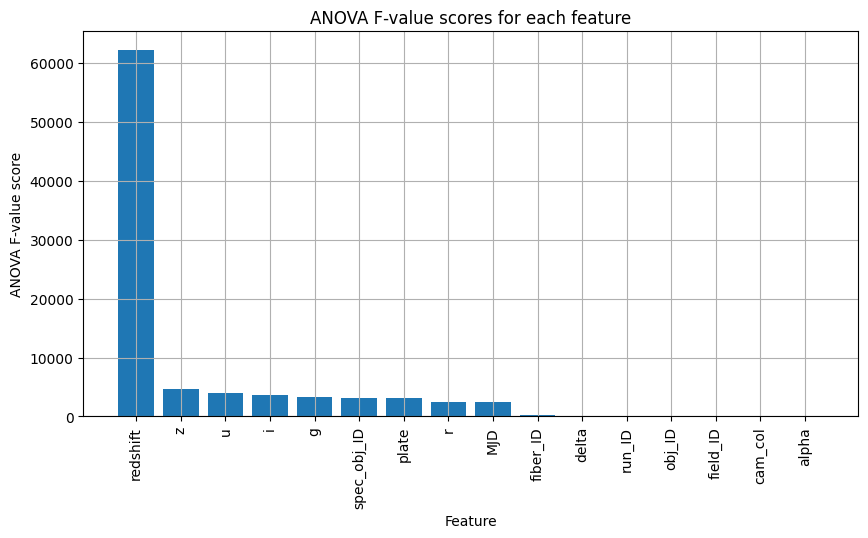

In [24]:
plot_feature_scores(select_k_best.scores_, star_features_names, 'ANOVA F-value')

Based on the plot above, we can see that the top 9 features `redshift`, `z`, `u`, `i`, `g`, `spec_obj_ID`, `plate`, `r`, and `MJD` have significantly higher ANOVA F-values than the other features, thus they have a stronger influence on the target. Additionally, the upon further investigation into what each column represents through visiting [Kaggle](https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17), seemingly these features are the most relevant to the classification of an object as a star, galaxy, or quasar.

Therefore, the features that will be dropped are:
- `obj_ID`: given that it is just an identifier, it does not provide any useful information for classification and would only add noise to the model.
- `alpha`: this feature represents the right ascension of the object, which is a coordinate used to locate objects in the sky. It shouldn't provide any benefit to the model in the classification of an object as a star, galaxy, or quasar as they are distributed across the sky.
- `delta`: similar to `alpha`, this column represents the declination of the object, which is also a coordinate for locating objects thus it shouldn't provide any benefit to the model.
- `run_ID`: this feature refers to a specific scan of the sky, which is an identifier for the run that the object was observed in. It shouldn't provide any benefit to the model as it isn't related to the detection of an object as a star, galaxy, or quasar.
- `cam_col`: this feature represents the camera column used during the observation. Like the `run_ID`, it is not related to the object's properties thus is less relevant to the classification task.
- `field_ID`: this feature represents the field number of the observation. It is also not related to the object's properties so shouldn't be relevant to the classification task.
- `fiber_ID`: this refers to the fiber number used to capture the spectrum of the object. The feature is not related to the object's properties so won't provide any benefit to the model.

In [25]:
# Get the indices of the columns to drop
drop_columns = np.argsort(select_k_best.scores_)[::-1][9:]
star_features_selected = np.delete(star_features_standardised, drop_columns, axis=1)
star_features_names_selected = np.delete(star_features_names, drop_columns)

# Print the remaining features
print(f'The remaining features are: {star_features_names_selected}')

The remaining features are: ['u' 'g' 'r' 'i' 'z' 'spec_obj_ID' 'redshift' 'plate' 'MJD']


Finally, we can visualise the correlation between the remaining features using a Pearson correlation matrix. This will help to identify any features that are highly correlated with each other and aid in analysing the results of the classification models.

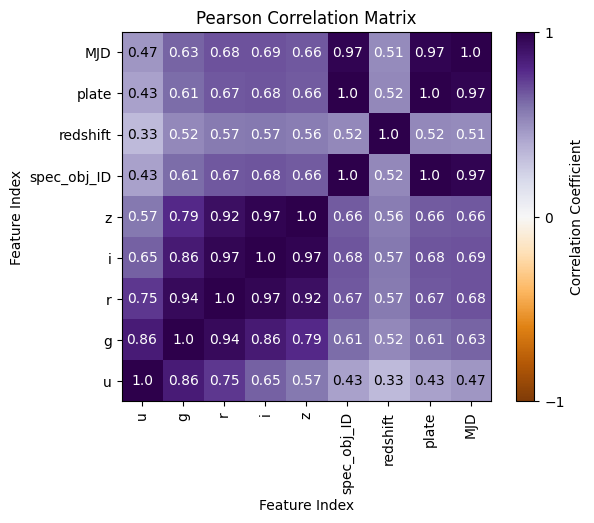

In [26]:
plot_feature_correlations(star_features_selected, star_features_names_selected)

From this matrix, it is clear that the following features are highly correlated:
- `u`, `g`, `r`, `i` and `z` have a chain of correlations
- `spec_obj_ID`, `plate` and `MJD` have linear correlations

It makes sense that several of the features related to the photometric system are correlated as they represent the intensity of the object's light at different wavelengths. Since objects emit light across a range of wavelengths, it is expected that the light will be correlated across the different filters.

This concludes the preprocessing of the star dataset. The next step is to perform the same preprocessing steps on the GWP dataset.

## GWP Dataset <a class="anchor" id="GWP-Dataset"></a>

In this section, any steps in preprocessing in which multiple methods are tested that have also been performed for the star dataset e.g. feature scaling, for readability purposes they will not be explained again. Instead, refer to the section above for an explanation of the steps.

#### Load the GWP dataset <a class="anchor" id="Load-the-GWP-dataset"></a>

The next dataset that will be loaded in is the GWP dataset. Since this dataset contains a mixture of data types, the columns will be loaded in separately and then combined into a single dataset once the strings have been encoded.

In [27]:
gwp_file_name = 'gwp_assessment.csv'

# Load the categorical string columns
gwp_categorical = np.genfromtxt(gwp_file_name, delimiter=',', skip_header=True, encoding="utf-8", dtype=str, usecols=range(0, 4))
gwp_categorical_names = np.genfromtxt(gwp_file_name, delimiter=',', encoding="utf-8", dtype=str, usecols=range(0, 4), max_rows=1)

# Load the numerical columns
gwp_numerical = np.genfromtxt(gwp_file_name, delimiter=',', skip_header=True, encoding="utf-8", dtype=np.float64, usecols=range(4, 14))
gwp_numerical_names = np.genfromtxt(gwp_file_name, delimiter=',', encoding="utf-8", dtype=str, usecols=range(4, 14), max_rows=1)

gwp_values = np.genfromtxt(gwp_file_name, delimiter=',', skip_header=True, encoding="utf-8", dtype=np.float64, usecols=14)

Next let's explore the dataset to determine the number of samples, features and classes.

In [28]:
print(f'Number of samples: {gwp_categorical.shape[0]}')
print(f'Number of features: {gwp_categorical.shape[1] + gwp_numerical.shape[1]}')
print(f'Number of classes: {np.unique(gwp_values).shape[0]}')

Number of samples: 1197
Number of features: 14
Number of classes: 879


Since there are 879 unique classes, this is clearly a regression task. Additionally, unlike the star dataset, since there are categorical features in this dataset, these will need to be explored and encoded appropriately

#### Filling in missing categorical features <a class="anchor" id="Filling-in-missing-categorical-features"></a>

First let's look at the categorical features to determine if there are any missing values.

In [29]:
# Count the number of missing values in each column
missing_vals = np.sum(gwp_categorical == '', axis=0)
for k, v in enumerate(missing_vals):
    print(f'{gwp_categorical_names[k]}: {v} missing values')
print(f'Total: {sum(missing_vals)} missing values')

date: 18 missing values
quarter: 11 missing values
department: 7 missing values
day: 15 missing values
Total: 51 missing values


Let's take a look at the `quarter`, `date` and `day` features first.

In [30]:
unique_quarter_values, counts = np.unique(gwp_categorical[:, 1], return_counts=True)

# Print unique values along with their counts
for value, count in zip(unique_quarter_values, counts):
    print(f"Value: {value}, Count: {count}")

Value: , Count: 11
Value: Quarter1, Count: 357
Value: Quarter2, Count: 332
Value: Quarter3, Count: 207
Value: Quarter4, Count: 246
Value: Quarter5, Count: 44


To gain a better understanding of the `quarter` feature, let's plot it against the date.

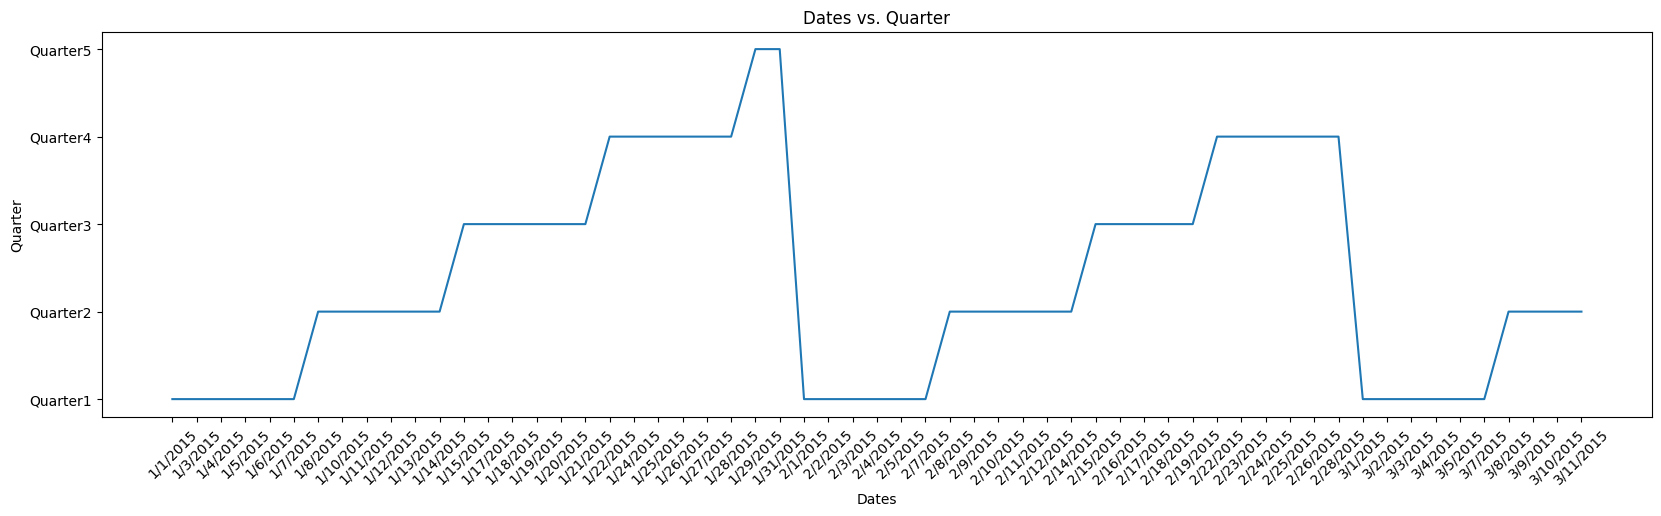

In [31]:
plt.figure(figsize=(20, 5))
gwp_categorical_no_nulls = gwp_categorical[~(gwp_categorical == '').any(axis=1)]
plt.plot(gwp_categorical_no_nulls[:, 0], gwp_categorical_no_nulls[:, 1])
plt.xlabel('Dates')
plt.ylabel('Quarter')
plt.title('Dates vs. Quarter')
plt.xticks(rotation=45)

plt.show()

From the plot above, it is clear that quarters 1, 2, 3 and 4 usually follow a consistent pattern in their length (one week, the null values could explain some deviation from this pattern) and when they occur (start every Thursday). The main point of deviation from this pattern is quarter 5, which happens once and appears to last for only two days. This could potentially be an error in the dataset, but we can't be sure without further information. Based on this information, it is clearly possible to infer the missing values in the `quarter`, `date` and `day` features if at most one of these features is missing in a given sample.

In [32]:
# Create a 2D array of booleans indicating which samples are missing values in each of the date, day and quarter features
missing_samples = np.column_stack((gwp_categorical[:, 0] == '', gwp_categorical[:, 1] == '', gwp_categorical[:, 3] == ''))
# Count the number of missing values in each row
missing_count = np.sum(missing_samples, axis=1)
# Find the indices of the rows with more than one missing value
rows_with_multiple_missing = np.where(missing_count > 1)[0]

print(f'Number of rows with more than one missing value: {rows_with_multiple_missing.shape[0]}')

Number of rows with more than one missing value: 0


Since no rows are missing more than one of the date, day and quarter features, we are able to infer the missing values in these features.

In [33]:
gwp_categorical_filled = fill_gwp_missing_days(fill_gwp_missing_quarters(fill_gwp_missing_dates(gwp_categorical)))

Now that the missing values in the `date`, `day` and `quarter` features have been filled, let's look at the `department` feature.

In [34]:
unique_values, counts = np.unique(gwp_categorical_filled[:, 2], return_counts=True)

# Print unique values along with their counts
for value, count in zip(unique_values, counts):
    print(f'Value: {value}, Count: {count}')

Value: , Count: 7
Value: finishing, Count: 246
Value: finishing , Count: 257
Value: sweing, Count: 687


There appears to be two departments, `sewing` and `finishing`. However, some `finishing` values have been entered with a trailing space and `sewing` is spelt incorrectly. Additionally, we can infer the missing values in the feature from the `wip` column - if the `wip` value is null, then the `department` value should be `finishing`, otherwise it should be `sewing` (this was discovered later in this notebook).

In [35]:
gwp_categorical_filled = handle_gwp_department(gwp_categorical_filled, gwp_numerical[:, 3])

missing_vals = np.sum(gwp_categorical_filled == '', axis=0)
for k, v in enumerate(missing_vals):
    print(f'{gwp_categorical_names[k]}: {v} missing values')
print(f'Total: {sum(missing_vals)} missing values')

date: 0 missing values
quarter: 0 missing values
department: 0 missing values
day: 0 missing values
Total: 0 missing values


Let's now convert the `date` feature into several numerical features: `year`, `month` and `day`.

In [36]:
gwp_categorical_date_encoded, gwp_categorical_names = convert_date_to_cols(gwp_categorical_filled, 0, X_labels=gwp_categorical_names)

print(f'Categorical features: {gwp_categorical_names}')

Categorical features: ['year' 'month' 'day' 'quarter' 'department' 'day']


#### Encoding the categorical features <a class="anchor" id="Encoding-the-categorical-features"></a>

The next step is to encode the categorical features that are still strings, namely `quarter`, `department` and `day`. Several encoding methods exist that will be explored, including:
1. Ordinal encoding
2. One-hot encoding

Several other methods also exist such as binary encoding, however these are not included with Scikit-learn and so will not be explored here.

**1. Ordinal encoding**

Ordinal encoding involves assigning each unique value in a categorical feature an integer to represent it. This is the simplest encoding method and is most useful when the values in the feature have a natural order. However, ordinal encoding can also bring some disadvantages that can be alleviated with other methods, such as models mistakenly assuming that the values are continuous rather than categorical.

In [37]:
oc = OrdinalEncoder()
gwp_categorical_oc = np.hstack((gwp_categorical_date_encoded[:, [0, 1, 2]] ,oc.fit_transform(gwp_categorical_date_encoded[:, [3, 4, 5]])))

print(f'Categorical features: {gwp_categorical_names}')

Categorical features: ['year' 'month' 'day' 'quarter' 'department' 'day']


**2. One-hot encoding**

One-hot encoding involves creating a new column for each unique value in a categorical feature. A single column is set to 1 in each row, with the rest set to 0. This is more complex than ordinal encoding but is more useful in many cases, like when features don't have a natural order. However, it does possess some disadvantages, such as increasing the dimensionality of the dataset and potentially introducing multicollinearity (when two or more features are highly correlated).

In [38]:
ohc = OneHotEncoder(categories='auto', dtype=float, sparse_output=False)
gwp_categorical_ohc = np.hstack((gwp_categorical_date_encoded[:, [0, 1, 2]], ohc.fit_transform(gwp_categorical_date_encoded[:, [3, 4, 5]])))

# Save the feature names
gwp_categorical_names = np.hstack((gwp_categorical_names[:3], ohc.get_feature_names_out(['quarter', 'department', 'day'])))
print(f'Categorical features: {gwp_categorical_names}')

Categorical features: ['year' 'month' 'day' 'quarter_Quarter1' 'quarter_Quarter2'
 'quarter_Quarter3' 'quarter_Quarter4' 'quarter_Quarter5'
 'department_finishing' 'department_sewing' 'day_Monday' 'day_Saturday'
 'day_Sunday' 'day_Thursday' 'day_Tuesday' 'day_Wednesday']


One-hot encoding will be used for the categorical features in this dataset as the advantages it brings outweigh the disadvantages. Next, the numerical features will be explored.

#### Filling in missing numerical features <a class="anchor" id="Filling-in-missing-numerical-features"></a>

First, let's again determine the number of missing values in each column.

In [39]:
# Count the number of missing values in each column
missing_numerical_vals = np.sum(np.isnan(gwp_numerical), axis=0)
for k, v in enumerate(missing_numerical_vals):
    print(f'{gwp_numerical_names[k]}: {v} missing values')
print(f'Total: {sum(missing_numerical_vals)} missing values')

team: 12 missing values
targeted_productivity: 17 missing values
smv: 8 missing values
wip: 506 missing values
over_time: 9 missing values
incentive: 5 missing values
idle_time: 12 missing values
idle_men: 12 missing values
no_of_style_change: 13 missing values
no_of_workers: 10 missing values
Total: 604 missing values


Evidently the `wip` feature has a large number of missing values that are related to the `department` column in each sample, so let's plot a bar chart of `wip` against `department` to see if we can understand the missing values.

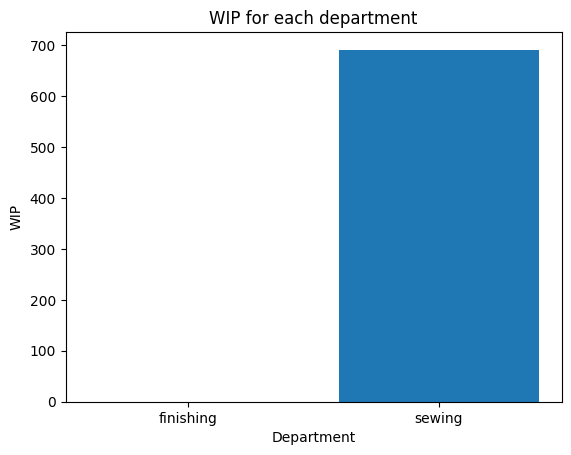

In [40]:
# Plot a bar chart of the `wip` feature for each department
department = np.unique(gwp_categorical_filled[:, 2])
# Count the number of non-null values in the `wip` feature for each department
wip = np.zeros(department.shape[0])
for i, dept in enumerate(department):
    wip[i] = np.sum(~np.isnan(gwp_numerical[gwp_categorical_filled[:, 2] == dept, 3]))

plt.figure()
plt.bar(department, wip)
plt.xlabel('Department')
plt.ylabel('WIP')
plt.title('WIP for each department')
plt.show()

From the plot above, it is clear that the `wip` feature is missing for all samples in the `finishing` department. Based on the definition of the `wip` feature (work in progress, includes the number of unfinished items for products), it appears to be not applicable to the `finishing` department. Therefore, we can just fill in the missing values with zeros where the department is `finishing`.

In [41]:
# Fill in the missing values in the `wip` feature with zeros when the department is `finishing`
gwp_numerical[(gwp_categorical_filled[:, 2] == 'finishing') & (np.isnan(gwp_numerical[:, 3])), 3] = 0

For the remaining missing values, we can apply various imputation methods to fill them in. This includes:
1. Remove the samples with missing values
2. Fill the missing values with a constant
3. Fill the missing values with the mean/median of the column
4. Fill the missing values based on the values of the other features

First, we will combine the categorical and numerical features into a single array as this may be useful for some imputation methods.

In [42]:
gwp_features = np.hstack((gwp_categorical_ohc, gwp_numerical)).astype(float)
gwp_features_names = np.hstack((gwp_categorical_names, gwp_numerical_names))

**1. Remove the samples with missing values**

In [43]:
gwp_features_rm = gwp_features[~np.isnan(gwp_features).any(axis=1)]

print(f'Total: {sum(np.sum(np.isnan(gwp_features_rm), axis=0))} missing values')

Total: 0 missing values


**2. Fill the missing values with a constant**

In [44]:
simple_imputer_constant = SimpleImputer(strategy='constant', fill_value=0)
gwp_features_constant = simple_imputer_constant.fit_transform(gwp_features)

print(f'Total: {sum(np.sum(np.isnan(gwp_features_constant), axis=0))} missing values')

Total: 0 missing values


**3. Fill the missing values with the mean/median of the column**

In [45]:
simple_imputer_mean = SimpleImputer(strategy='mean')
gwp_features_mean = simple_imputer_mean.fit_transform(gwp_features)

print(f'Total: {sum(np.sum(np.isnan(gwp_features_mean), axis=0))} missing values')

Total: 0 missing values


**4. Fill the missing values based on the values of the other features**

In [46]:
knn_imputer = KNNImputer()
gwp_features_imputed = knn_imputer.fit_transform(gwp_features)

print(f'Total: {sum(np.sum(np.isnan(gwp_features_imputed), axis=0))} missing values')

Total: 0 missing values


Again, the KNNImputer will be the method used since it tends to provide the best results, and prevents the model becoming biased on a single value. Additionally, given the small size of the dataset, we cannot afford to drop any rows of data.

#### Encoding the remaining categorical feature <a class="anchor" id="Encoding-the-remaining-categorical-feature"></a>

Next, let's one-hot encode the `team` feature as it can be considered a categorical feature. Before this, we need to round the values in the `team` feature to the nearest integer as they may have been imputed with decimal values.

In [47]:
# Round the values in the `team` feature to the nearest integer
team_idx = np.where(gwp_features_names == 'team')[0][0]
gwp_features_imputed[:, team_idx] = np.round(gwp_features_imputed[:, team_idx])

Now the `team` feature can be one-hot encoded.

In [48]:
# One-hot encode the `team` feature then replace the original `team` feature with the encoded features
ohc = OneHotEncoder(categories='auto', dtype=float, sparse_output=False)
team_encoded = ohc.fit_transform(gwp_features_imputed[:, [team_idx]])
gwp_features_encoded = np.hstack((gwp_features_imputed[:, :team_idx], team_encoded, gwp_features_imputed[:, team_idx+1:]))
gwp_features_names = np.hstack((gwp_features_names[:team_idx], ohc.get_feature_names_out(['team']), gwp_features_names[team_idx+1:]))

print(f'Features: {gwp_features_names}')

Features: ['year' 'month' 'day' 'quarter_Quarter1' 'quarter_Quarter2'
 'quarter_Quarter3' 'quarter_Quarter4' 'quarter_Quarter5'
 'department_finishing' 'department_sewing' 'day_Monday' 'day_Saturday'
 'day_Sunday' 'day_Thursday' 'day_Tuesday' 'day_Wednesday' 'team_1.0'
 'team_2.0' 'team_3.0' 'team_4.0' 'team_5.0' 'team_6.0' 'team_7.0'
 'team_8.0' 'team_9.0' 'team_10.0' 'team_11.0' 'team_12.0'
 'targeted_productivity' 'smv' 'wip' 'over_time' 'incentive' 'idle_time'
 'idle_men' 'no_of_style_change' 'no_of_workers']


#### Removing samples with outliers <a class="anchor" id="Removing-samples-with-outliers-GWP"></a>

Now that the missing values have been dealt with and the categorical features have been encoded, we can look to remove samples with outliers. Therefore, let's create box plots for each feature to gain an understanding of the distribution of the data. We can ignore the features that have been one-hot encoded as they are binary features, along with the date features.

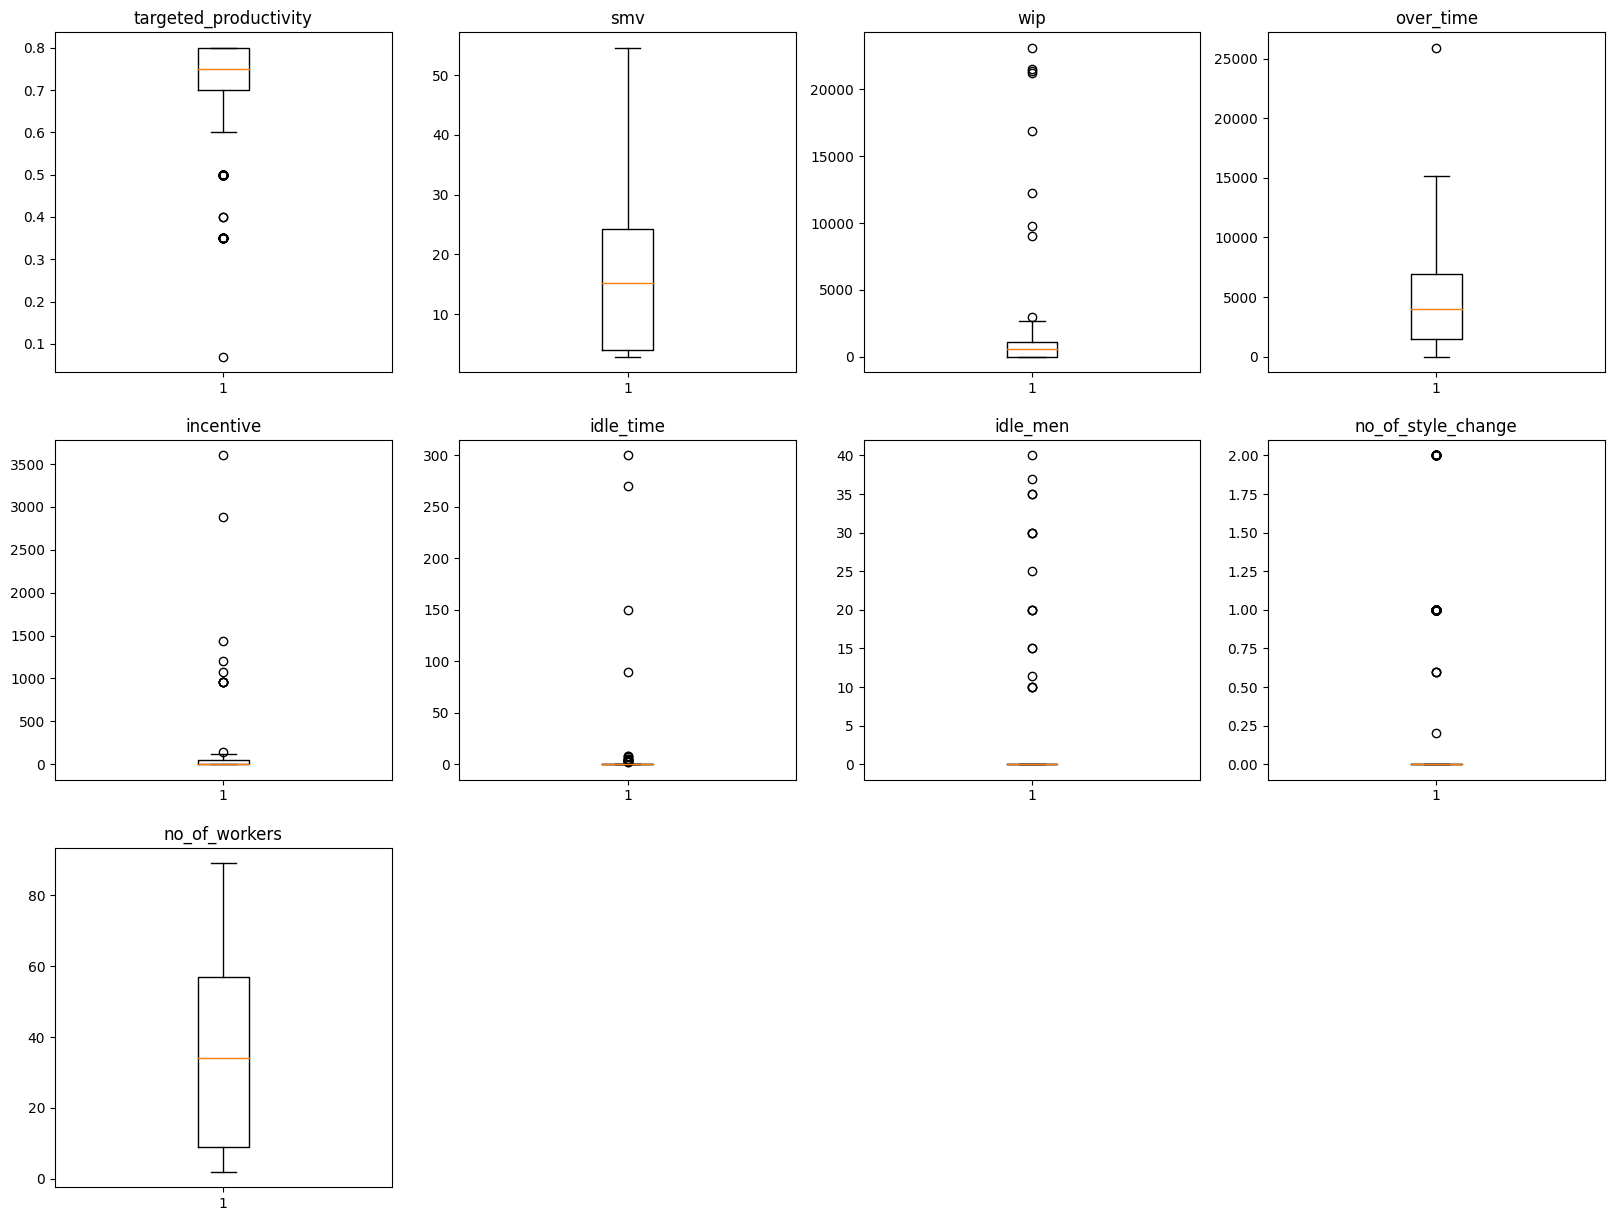

In [49]:
plot_feature_boxplot(gwp_features_encoded, gwp_features_names, ignore_cols=list(range(0, 28)))

Based on these box plots we can see that several features have outliers. However, due to the `idle_time`, `idle_men`, and `no_of_style_change` features having a very small mean and interquartile range, it is likely that many of the outliers are only indicated as such due to most of the values being zero. Therefore, we will ignore these features when removing outliers.

In [50]:
ignored_features = list(range(0, 28)) + list(range(33, 36))
# Get the indices of the features that are not ignored
outlier_features = [i for i in range(gwp_features_encoded.shape[1]) if i not in ignored_features]


Like with the previous dataset, there are several ways of doing this:
1. Using Scikit-Learn's LocalOutlierFactor
2. Using Scikit-Learn's IsolationForest
3. Using the Interquartile Range (IQR) method

**1. Using Scikit-Learn's LocalOutlierFactor**

In [51]:
lof = LocalOutlierFactor(contamination=0.5)
outlier_scores = lof.fit_predict(gwp_features_encoded[:, outlier_features])

# Get the indices of the outliers
outlier_indices = np.where(outlier_scores == -1)[0]
gwp_features_lof = gwp_features_encoded[outlier_indices, :]

print(f'Number of samples removed: {gwp_features_encoded.shape[0] - gwp_features_lof.shape[0]}')

Number of samples removed: 599


**2. Using Scikit-Learn's IsolationForest**

In [52]:
isf = IsolationForest(contamination=0.5)
outlier_scores = isf.fit_predict(gwp_features_encoded[:, outlier_features])

# Get the indices of the outliers
outlier_indices = np.where(outlier_scores == -1)[0]
gwp_features_isf = gwp_features_encoded[outlier_indices, :]

print(f'Number of samples removed: {gwp_features_encoded.shape[0] - gwp_features_isf.shape[0]}')

Number of samples removed: 599


**3. Using the Interquartile Range (IQR) method**

In [53]:
gwp_features_iqr, gwp_values_iqr = remove_iqr_outliers(gwp_features_encoded, gwp_values, ignore_cols=ignored_features)

print(f'Number of samples removed: {gwp_features_encoded.shape[0] - gwp_features_iqr.shape[0]}')

Number of samples removed: 99


Evidently the IQR method is the only one that doesn't remove an unreasonable number of samples, even after attempting to optimise the contamination value for the LocalOutlierFactor and the IsolationForest. Therefore, we will use the IQR method to remove outliers.

#### Removing features with no variance <a class="anchor" id="Removing-features-with-no-variance-GWP"></a>

Next, we will remove any features that have no variance as they will not be useful for training a model.

In [54]:
gwp_features_no_variance_removed, gwp_features_names = remove_no_variance(gwp_features_iqr, gwp_features_names)

print(f"Remaining features: {gwp_features_names}")

Remaining features: ['month' 'day' 'quarter_Quarter1' 'quarter_Quarter2' 'quarter_Quarter3'
 'quarter_Quarter4' 'quarter_Quarter5' 'department_finishing'
 'department_sewing' 'day_Monday' 'day_Saturday' 'day_Sunday'
 'day_Thursday' 'day_Tuesday' 'day_Wednesday' 'team_1.0' 'team_2.0'
 'team_3.0' 'team_4.0' 'team_5.0' 'team_6.0' 'team_7.0' 'team_8.0'
 'team_9.0' 'team_10.0' 'team_11.0' 'team_12.0' 'targeted_productivity'
 'smv' 'wip' 'over_time' 'incentive' 'idle_time' 'idle_men'
 'no_of_style_change' 'no_of_workers']


In this case, only the `year` feature has been removed.

#### Feature scaling <a class="anchor" id="Feature-scaling-GWP"></a>

Now that the data has been cleaned, we can scale the feature before performing feature selection. This can be done in several ways:
1. Scaling the features between 0 and 1
2. Scaling the features between -1 and 1
3. Standardising the features to have a mean of 0 and a standard deviation of 1

**1. Scaling the features between 0 and 1**

In [55]:
mm_scaler = MinMaxScaler()
gwp_features_mm_scaled = mm_scaler.fit_transform(gwp_features_no_variance_removed)

**2. Scaling the features between -1 and 1**

In [56]:
ma_scaler = MaxAbsScaler()
gwp_features_ma_scaled = ma_scaler.fit_transform(gwp_features_no_variance_removed)

**3. Standardising the features to have a mean of 0 and a standard deviation of 1**

In [57]:
std_scaler = StandardScaler()
gwp_features_standardised = std_scaler.fit_transform(gwp_features_no_variance_removed)

Like with the star dataset, we will use the standardised features for feature selection.

#### Feature selection using the filter method <a class="anchor" id="Feature-selection-using-the-filter-method-GWP"></a>

For performing feature selection on this dataset, we will use the Pearson correlation coefficient as the target variable is continuous. A threshold of 0.1 will be used as a guideline to select the features, along with knowledge gained through looking at the definition of each feature.

In [58]:
select_k_best = SelectKBest(score_func=r_regression)
select_k_best.fit(gwp_features_standardised, gwp_values_iqr)

SelectKBest(score_func=<function r_regression at 0x00000218057B7520>)

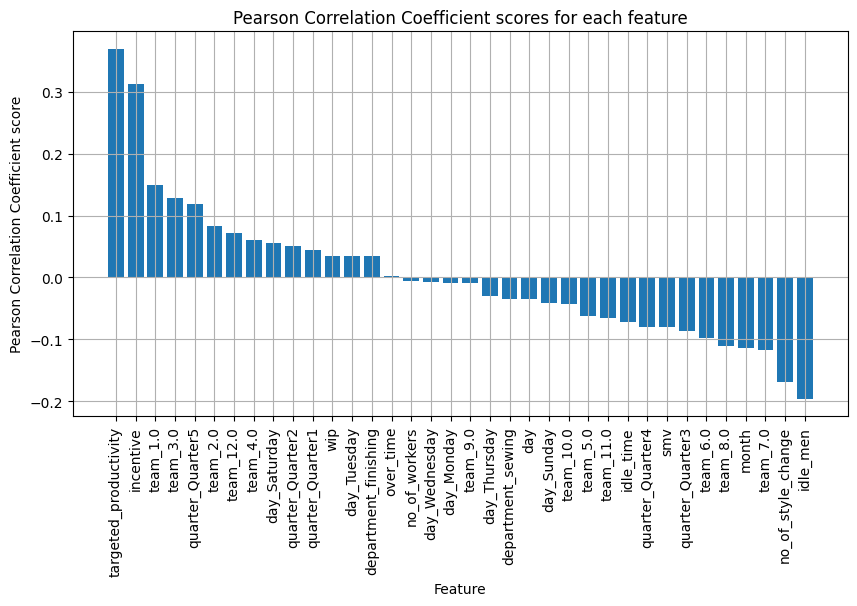

In [59]:
plot_feature_scores(select_k_best.scores_, gwp_features_names, 'Pearson Correlation Coefficient')

Based on the plot above and domain knowledge gained through reading the feature definitions on Kaggle, we can select the following features:
- `team` (one-hot encoded): despite all the one-hot encoded `team` features not having a correlation coefficient greater than 0.1, we will keep all of them as they are all related to the same feature.
- `targeted_productivity`: this feature has the highest correlation coefficient.
- `smv`: this feature has a correlation coefficient slightly greater than -0.1, but it makes sense that the standard minute value of a task would affect the productivity.
- `incetive`: this feature has a correlation coefficient greater than 0.1, and represents the financial incentive that enables a course of action.
- `idle_men`: this feature also has a correlation coefficient less than -0.1, and relates to the number of workers that were idle due to production interruption.
- `no_of_style_change`: this feature has a correlation coefficient less than -0.1, and represents the number of times the style of a product was changed during production.
- `month`: this feature has a correlation coefficient less than -0.1, and represents the month in which the sample was collected.

In [60]:
# Only keep the selected features
selected_features = list(range(15, 27)) + [0, 27, 28, 31, 33, 34]
gwp_features_selected = gwp_features_standardised[:, selected_features]
gwp_features_names = gwp_features_names[selected_features]

# Print the number of features
print(f'Selected features: {gwp_features_names}')

Selected features: ['team_1.0' 'team_2.0' 'team_3.0' 'team_4.0' 'team_5.0' 'team_6.0'
 'team_7.0' 'team_8.0' 'team_9.0' 'team_10.0' 'team_11.0' 'team_12.0'
 'month' 'targeted_productivity' 'smv' 'incentive' 'idle_men'
 'no_of_style_change']


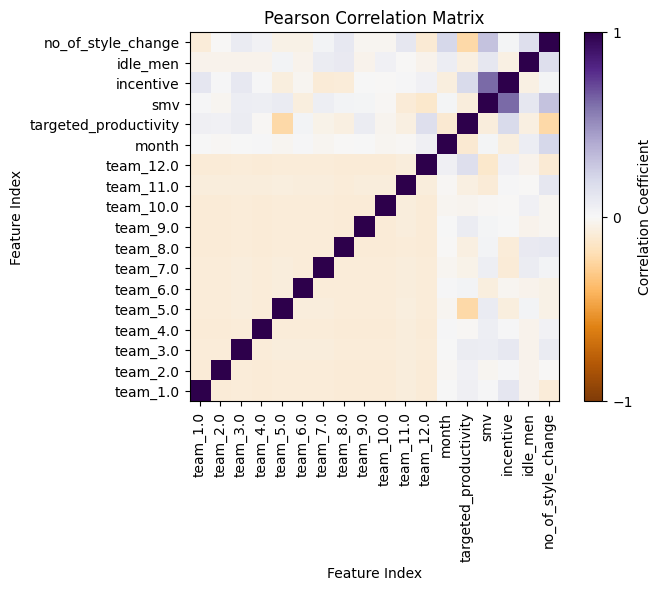

In [61]:
plot_feature_correlations(gwp_features_selected, gwp_features_names, show_coef=False)

The matrix shows that none of the selected features have a particularly high correlation with each other, which is good as it means that there is unlikely to be any multicollinearity.

## Markdown Question <a class="anchor" id="Markdown-Question"></a>

*Explain the logic behind usage of Pearson correlation coefficient for feature selection.*

Using the Pearson correlation coefficient for feature selection is mostly suitable when the target variable is continuous because it is a measure of the linear relationship between two variables. It can be used to measure the strength and correlation between each feature and the target variable to determine which have the greatest impact. The result for each feature is a value between -1 and 1, where -1 indicates a strong negative correlation, 0 indicates no correlation, and 1 indicates a strong positive correlation. Therefore, it is relatively simple to interpret the relationship between features and the target. It is common to set a threshold for coefficient values based on domain knowledge to determine which features to select. The Pearson correlation coefficient can also be used to identify features that have a high level of correlation with each other, with the aim of reducing multicollinearity.

In the context of feature selection in the two datasets pre-processed in this notebook, it was used to identify which features are most relevant to the target variable for the GWP dataset as the target was continuous. In contrast, it was not used for the STAR dataset as the target was categorical with more than two classes, but instead for examining the relationship between continuous features.